In [1]:
%pylab inline --no-import-all

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# SSH Model

Here we consider the SSH model as presented and discussed in [[Léséleuc:2019]](https://science.sciencemag.org/content/365/6455/775) which represents a finite 1D lattice of fermions with the following Hamiltonian (from their supplement):

\begin{gather}
  H_F = - J_1\sum_{i=1}^{L}c_{2i-1}^\dagger c_{2i} 
        - J_2\sum_{i=1}^{L-1}c_{2i}^\dagger c_{2i+1}.\tag{S3}
\end{gather}

## Brute Force Diagonalization
* np.kron is the tensor product operation

In [2]:
import numpy as np
def get_c(N, n):
    c = np.array([[0, 0], 
                    [1, 0]])
    one = np.eye(2)
    factors = [one]*N
    factors[n] = c
    res = 1
    for f in factors:
        res = np.kron(res, f)
    return res
    
def get_cs(N):
    """Return a list of the operators c_i.
    
    Arguments
    ---------
    N : int
        N = 2L = number of lattice sites.
    """    
    cs = []
    for n in range(N):
        res = get_c(N=N, n=n)
        cs.append(res)
    return cs

def get_H(L=4, J1=1, J2=2, get_cs=get_cs):
    """Return the Hamiltonian for a chain of N=2L sites.
    """
    N = 2*L
    cs = get_cs(N)
    H1 = 0
    H2 = 0
    for i in range(1, L+1):
        # -1 for 0-indexing in python
        H1 += cs[2*i-1-1].T.dot(cs[2*i-1])
    for i in range(1, L):
        H2 += cs[2*i-1].T.dot(cs[2*i+1-1])
    H = -(J1*H1 + J2*H2)
    return H + H.T

%time H = get_H(L=5)
%time E, psi = np.linalg.eigh(H)

CPU times: total: 1.03 s
Wall time: 344 ms
CPU times: total: 46.9 ms
Wall time: 389 ms


In [3]:
c = get_c(N=10, n=1)
ct = c.T
op = np.matmul(ct, c)

Here we plot the energes of the lowest excited states.  In the topological phase, the energy of the ground state has a four-fold degeneracy, so there are three degenerate "excited" states in the plot since we subtract off the energy of the ground state.

In [4]:
def get_Ns(N, state_id=0, J1=1, J2=2):
    """
    return occupancy number for given manybody state id
    """
    H = get_H(L=N//2, J1=J1, J2=J2)
    E, psi = np.linalg.eigh(H)
    Ns = []
    for n in range(N):
        c = get_c(N=N, n=n)
        ct = c.T
        op_n = ct.dot(c)
        n_ = op_n.dot(psi[:,state_id])
        Ns.append(n_.dot(psi[:,state_id]))
    return Ns

[0.45242655929862463, 0.46023316022753136, 0.3718969719979839, 0.37946932879060585, 0.3359739796852542, 0.33597397968525405, 0.37946932879060724, 0.37189697199798527, 0.46023316022753225, 0.4524265592986258]
[0.0049999995609350135, 0.4999999951485061, 0.4950500000926403, 0.4999995050989954, 0.4999505000989275, 0.4999505000989276, 0.49999950509899516, 0.4950500000926403, 0.4999999951485061, 0.004999999560935008]


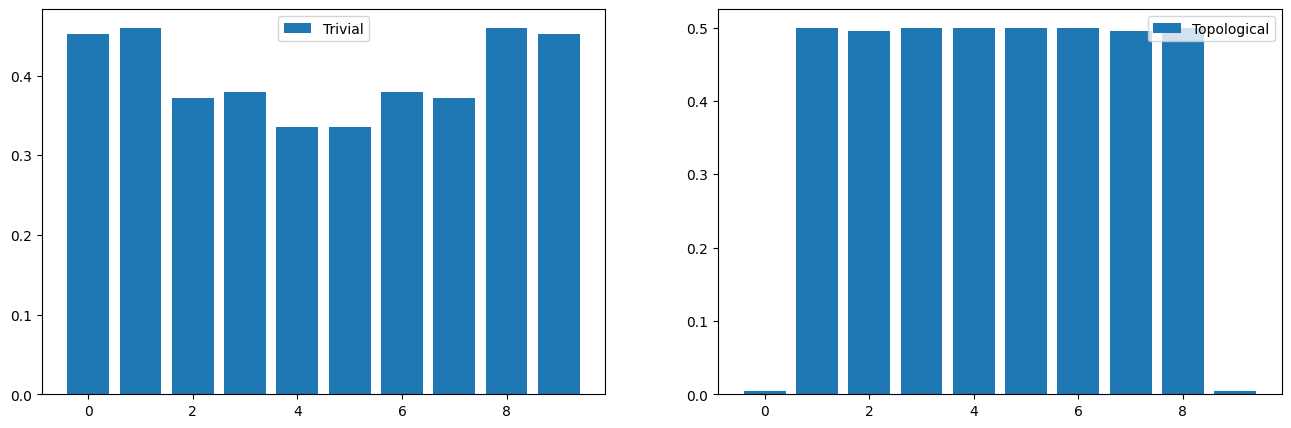

In [5]:
plt.figure(figsize=(16,5))
state_id = 1
Jprime=.1
J=1
Ns=get_Ns(N=10, state_id=state_id, J2=Jprime, J1=J)
print(Ns)
plt.subplot(121)
plt.bar(list(range(len(Ns))),Ns, label="Trivial")
plt.legend()
plt.subplot(122)
Ns=get_Ns(N=10, state_id=state_id, J2=J, J1=Jprime)
print(Ns)
plt.bar(list(range(len(Ns))),Ns, label="Topological")
plt.legend()

Text(0.5, 1.0, 'Excited State Energies')

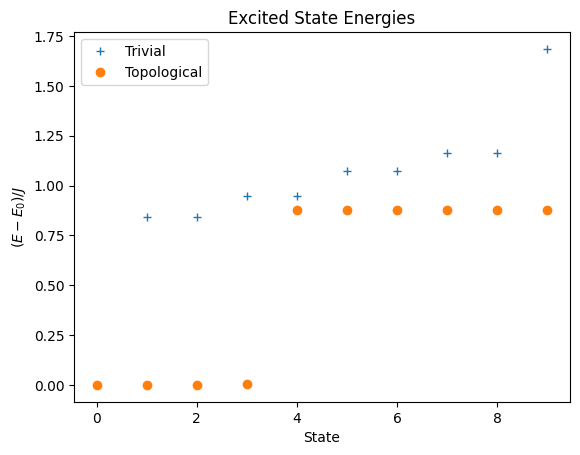

In [6]:
Nstates = 10
Jprime = 0.2
J = 1.0

# Trivial state
H = get_H(L=4, J1=J, J2=Jprime)
E = np.linalg.eigvalsh(H)
plt.plot(range(Nstates), (E[0:Nstates]-E[0])/J, '+', label='Trivial')

# Topological state:
H = get_H(L=4, J1=Jprime, J2=J)
E, psi = np.linalg.eigh(H)
plt.plot(range(Nstates), (E[0:Nstates]-E[0])/J, 'o', label='Topological')

plt.legend()
plt.xlabel("State")
plt.ylabel(r"$(E-E_0)/J$")
plt.title("Excited State Energies")

##### Exercise: Site Occupations

It would be nice to plot the occupancies.  Compute the expectation value of the occupation of each site by forming $n_i = c_i^\dagger c_i$ and plot these for the lowest states to see if these agree with the Fig. 1 in the paper.

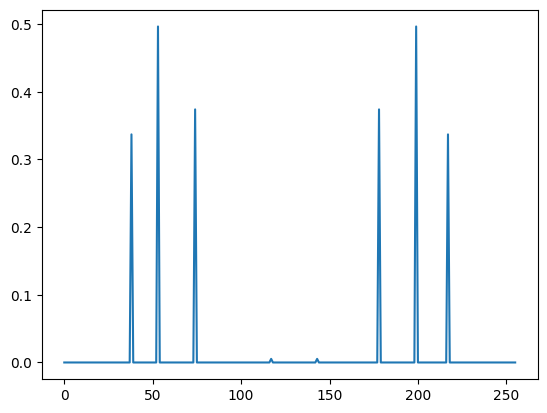

In [7]:
plt.plot(abs(psi[2, :]))

(-2.1, 2.1)

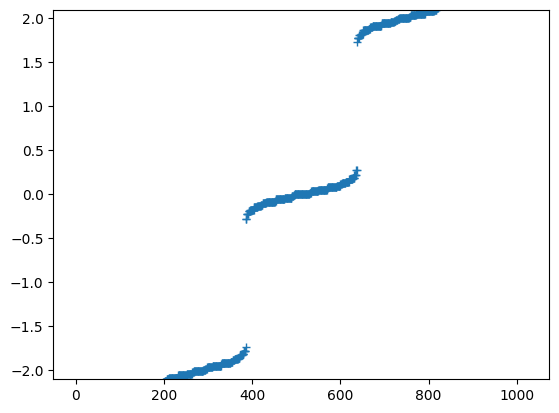

In [8]:
Jprime = 0.1
J = 2.0
H = get_H(L=5, J1=J, J2=Jprime)
E = np.linalg.eigvalsh(H)
#[plt.axhline(_E) for _E in E];
plt.plot(E, '+')
plt.ylim(-J-Jprime, J+Jprime)

(-2.1, 2.1)

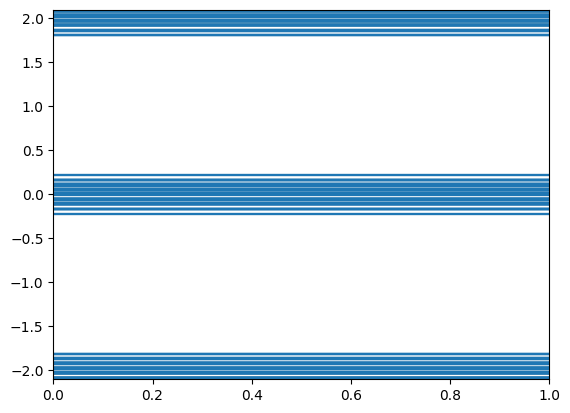

In [9]:
Jprime = 0.1
J = 2.0
H = get_H(L=5, J1=Jprime, J2=J)
E = np.linalg.eigvalsh(H)
[plt.axhline(_E) for _E in E];
plt.ylim(-J-Jprime, J+Jprime)

### Profiling

The maximum lattice size is about 6 or 7 if using full matrices ($L=7$ will take about an hour, $L=8$ will take about a day).

In [10]:
import time
reps = 3
ts = []
Ls = range(1, 6)
for L in Ls:
    tic = time.time()
    for n in range(reps):
        H = get_H(L=L)
        E = np.linalg.eigvalsh(H)
    ts.append((time.time()-tic)/reps)

def get_T(L, Ls=Ls, ts=ts):
    """Return the expected execution time in s."""
    return np.exp(np.polyval(np.polyfit(Ls[3:], np.log(ts[3:]), deg=1), L))

print(f"T_6~{get_T(L=6):.0f}s, T_7~{get_T(L=7)/60:.0f}min, T_8~{get_T(L=8)/60/60:.0f}h")

T_6~13s, T_7~4min, T_8~2h


## Sparse Implementation

In [11]:
import functools
import scipy.sparse.linalg
sp = scipy

def get_cs_sparse(N):
    """Return a list of the operators c_i.
    
    Arguments
    ---------
    N : int
        N = 2L = number of lattice sites.
    """
    c = sp.sparse.csr_matrix([[0, 0], [1, 0]])
    one = sp.sparse.eye(2)
    cs = []
    for n in range(N):
        factors = [one]*N
        factors[n] = c
        res = 1
        for f in factors:
            res = sp.sparse.kron(res, f, format='csr')
        cs.append(res)
    return cs

T_13~4612s
T_14~24932s
T_15~134766s


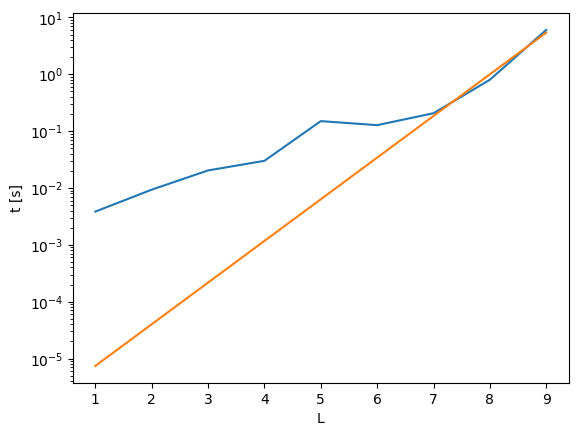

In [12]:
import time
reps = 3
ts = []
Ls = range(1, 10)
for L in Ls:
    tic = time.time()
    for n in range(reps):
        H = get_H(L=L, get_cs=get_cs_sparse)
        E, psi = sp.sparse.linalg.eigsh(H, k=min(H.shape[0]-1, 10))
    ts.append((time.time()-tic)/reps)

def get_T(L, Ls=Ls, ts=ts):
    """Return the expected execution time in s."""
    return np.exp(np.polyval(np.polyfit(Ls[-3:], np.log(ts[-3:]), deg=1), L))

_Ls = np.arange(1, 10)
plt.semilogy(Ls, ts);plt.xlabel('L');plt.ylabel('t [s]')
plt.semilogy(_Ls, [get_T(_L) for _L in _Ls])
for L0 in [13, 14, 15]:
    print(f"T_{L0}~{get_T(L=L0):.0f}s")

In [13]:
%time H = get_H(9, get_cs=get_cs_sparse)
H = H.tocsc()
%time E, psi = sp.sparse.linalg.eigsh(H, k=10)
E[:5]

CPU times: total: 156 ms
Wall time: 435 ms
CPU times: total: 1.47 s
Wall time: 5.7 s


array([-17.40537553, -17.40244577, -17.40244577, -17.39951601,
       -16.26731082])

CPU times: total: 922 ms
Wall time: 3.35 s


Text(0.5, 1.0, 'Excited State Energies')

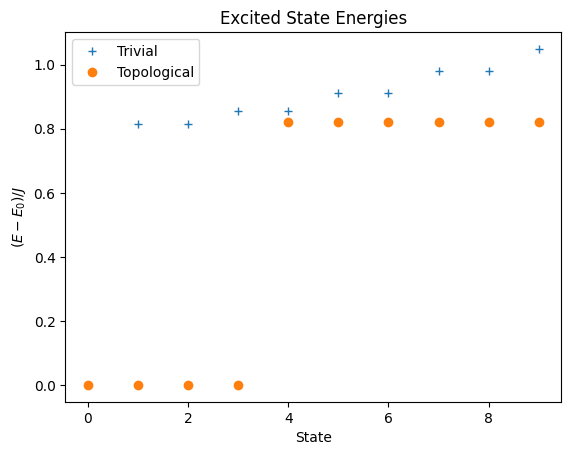

In [14]:
%%time 
L = 8
Nstates = 10
Jprime = 0.2
J = 1.0

# Trivial state
H = get_H(L=L, J1=J, J2=Jprime, get_cs=get_cs_sparse)
E, psi = sp.sparse.linalg.eigsh(H, k=2*Nstates)
plt.plot(range(Nstates), (E[0:Nstates]-E[0])/J, '+', label='Trivial')

# Topological state:
H = get_H(L=L, J1=Jprime, J2=J,get_cs=get_cs_sparse)
E, psi = sp.sparse.linalg.eigsh(H, k=2*Nstates)
plt.plot(range(Nstates), (E[0:Nstates]-E[0])/J, 'o', label='Topological')

plt.legend()
plt.xlabel("State")
plt.ylabel(r"$(E-E_0)/J$")
plt.title("Excited State Energies")

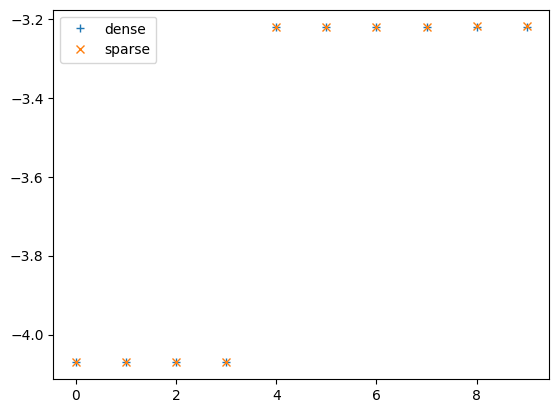

In [15]:
H0 = get_H(L=5, J1=Jprime, J2=J,get_cs=get_cs)
H = get_H(L=5, J1=Jprime, J2=J,get_cs=get_cs_sparse)
E0, psi0 = np.linalg.eigh(H0)
E, psi = sp.sparse.linalg.eigsh(H, k=2*Nstates)
plt.plot(range(Nstates), E0[:Nstates], '+', label='dense')
plt.plot(range(Nstates), E[:Nstates], 'x', label='sparse')
plt.legend()

# GPU

Be sure to select the GPU accelerator before using the following code.  This version works, and is fast, but the GPU memory is limited, so we cannot do more than $L=5$.

In [18]:
import cupy as cp

ModuleNotFoundError: No module named 'cupy'

In [ ]:
def get_cs_GPU(N):
    """Return a list of the operators c_i.

    Arguments
    ---------
    N : int
     N = 2L = number of lattice sites.
    """
    c = cp.array([[0, 0], 
                    [1, 0]])
    one = cp.eye(2)
    cs = []
    for n in range(N):
        factors = [one]*N
        factors[n] = c
        res = 1
        for m in range(N):
            # Implement the tensor product by using indices
            # and broadcasting.
            inds = [None, ]*2*N
            inds[m] = inds[N+m] = slice(None)
            res = res * factors[m][inds]
            cs.append(res.reshape(2**N, 2**N))
    return cs

def get_H_GPU(L=4, J1=1, J2=2, get_cs=get_cs_GPU):
    """Return the Hamiltonian for a chain of N=2L sites.
    """
    N = 2*L
    cs = get_cs(N)
    H = 0
    for i in range(1, L+1):
        # -1 for 0-indexing in python
        H += - J1*cs[2*i-1-1].T.dot(cs[2*i-1])
    for i in range(1, L):
        H += - J2*cs[2*i-1].T.dot(cs[2*i+1-1])
    return H + H.T

In [ ]:
%time H = get_H_GPU(L=6)
%time E, psi = cp.linalg.eigh(H)